<a href="https://colab.research.google.com/github/vibferreira/Data_Mining_UBS/blob/main/Kernel_2_BARBOSA_FERREIRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Assignment Kernel 2 - Time Elastic Similarity Spaces for Time Series Mining
### Code & Report

**Vitória Barbosa Ferreira** - e2008984
##### Data Mining - Copernicus Master in Digital Earth

This assigment consists on experimenting on Time Elastic Similarity Spaces for Time Series Mining. Question 1 digs into the Lavenshstein's distance (string similarity).

Questions 2 to 4 focus on time series mining and time series metrics to classify 83 individuals/users' finger-drawn signatures from the MOBISIG Dataset were taken with a capacitive touchscreen-based mobile device in this pseudo signature dataset. For each user there are 45 genuine signatures and 20 forged signatures, which were obtained using a device with a capacitive touchscreen. Each observation on the dataset consists of one point in the signature and columns representing the coordinates (x,y) time, pressure, finger area, and data saved from the accelerometer and gyroscope ([Szabó and Tordai, 2017)](https://www.hindawi.com/journals/misy/2018/3127042/)

The goal of this exercise is to classify the signatures on genuine or forged based on similarity metrics calculated from the series of signatures. In addition, the report also sheds light on the challenges found along the way.


For more information on the dataset consult: https://www.hindawi.com/journals/misy/2018/3127042/

## Data Loading

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# path on drive
path_ = '/content/drive/MyDrive/vitoria.barbosa.ferreira@usp.br 2021-08-09 21:44/Master/Copernicus - 15 01/Classes/3 semester/Data Mining/Time_Elastic_Kernels'

In [ ]:
# Data Loading
# -*- coding: utf-8 -*-
"""
Created on Sat Aug  3 16:41:48 2019

@author: pfm
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob, os, sys
import re, math
import argparse
from collections import Counter
from statistics import mode
# import eer



def normalizeMaxMin(V):
    M=np.max(V)
    m=np.min(V)
    V=(V-m)/(M-m)
    return V
    
def convertLine(l1):
    lout=[]
    l1=l1.split(' ')
    for e in l1:
        lout.append(float(e))
    return np.array(lout)


def convertLineMOBISIG(l1):
    lout=[]
    l1=re.split(' |,|;|\n|\t|\0',l1)
    #l1=l1.split(' ')
    ii=0
    if len(l1)>1:
        for e in l1:
            if e!="":
                if ii!=2 and ii!=4:
                    lout.append(float(e))
                ii+=1
                if ii==7:
                    break
    return np.array(lout)
    
    
def loadFile(fname, removeMean=True, withSpeed=False, withAcceleration=False):
    f = open(fname, 'r')
    lines=f.readlines()
    L=len(lines)
    data=[]
    for i in range(L):
        d=convertLine(lines[i])
        data.append(d)
    data = np.array(data)
    if withSpeed:
        dim=len(data[0])
        D=np.zeros((len(data),dim+2))
        for i in range(len(data)):
            D[i,0:dim]=data[i,:]
            if i>0:
                D[i,dim]=data[i,0]-data[i-1,0]
                D[i,dim+1]=data[i,1]-data[i-1,1]
        data=D

    dim=len(data[0])
    m=np.zeros(dim)
    if removeMean:
        sigma=np.zeros(dim)
        for k in range(dim):
            m[k]=np.mean(data[:,k])
            sigma[k]=np.std(data[:,k])
            data[:,k]=(data[:,k]-m[k])/sigma[k]
      
    if removeMean:
        M=np.zeros(dim)
        for k in range(dim):
            m[k]=np.min(data[:,k])
            M[k]=np.max(data[:,k])
            data[:,k]=(data[:,k]-m[k])/(M[k]-m[k])
            
    # Suppress Z==0
    D=[]
    for i in range(len(data)):
       if data[i,2]>.01:
           D.append(data[i,:])
    data=np.array(D)
    dim=len(data[0])
    if removeMean:
        sigma=np.zeros(dim)
        for k in range(dim):
            m[k]=np.mean(data[:,k])
            sigma[k]=np.std(data[:,k])
            data[:,k]=(data[:,k]-m[k])/sigma[k]

    return data

    
def loadFileMOBISIG(fname, removeMean=True, path='./DATA/'):
    f = open(fname, 'r')
    lines=f.readlines()
    L=len(lines)
    data=[]
    for i in range(1,L):
        if lines[i]!="\n":
          d=convertLineMOBISIG(lines[i])
          data.append(d)
    data = np.array(data)
    dim=len(data[0])
    m=np.zeros(dim)
    sigma=np.zeros(dim)
    '''if removeMean:

        for k in range(dim):
            m[k]=np.mean(data[:,k])
            sigma[k]=np.std(data[:,k])
            data[:,k]=(data[:,k]-m[k])/sigma[k]'''
      
    if removeMean:
        M=np.zeros(dim)
        for k in range(dim):
            m[k]=np.min(data[:,k])
            M[k]=np.max(data[:,k])
            data[:,k]=(data[:,k]-m[k])/(M[k]-m[k]) 
    # Suppress Z==0
    D=[]
    for i in range(len(data)):
       if data[i,2]>0:#.25:
           '''d=[]
           for k in range(dim):
               if k!=2:
                   d.append(data[i,k])
           D.append(np.array(d))'''
           D.append(data[i,:])
    data=np.array(D)
    dim=len(data[0])
    if removeMean:
        for k in range(dim):
            m[k]=np.mean(data[:,k])
            sigma[k]=np.std(data[:,k])
            data[:,k]=(data[:,k]-m[k])/sigma[k]  

    return data


def getGenuinesTrainTest_MOBISIG(uid, ntrain=5, path='./DATA/'):
    path += uid
    os.chdir(path)
    lfiles=[]
    for file in glob.glob("SIGN_GEN_*.csv"):
        lfiles.append(file)
    lfiles=sorted(lfiles)
    #I=np.arange(len(lfiles))
    np.random.shuffle(lfiles)
    if ntrain>len(lfiles)-1:
        ntrain=len(lfiles)-1
    genuineTrainFiles=lfiles[0:ntrain]
    genuineTestFiles=lfiles[ntrain:]
    return genuineTrainFiles, genuineTestFiles

def getForgeriesTest_MOBISIG(uid, path='./DATA/'):
    path += uid
    os.chdir(path)
    lfiles=[]
    for file in glob.glob("SIGN_FOR_*.csv"):
        lfiles.append(file)
    lfiles=sorted(lfiles)
    return lfiles


def loadTrainQuestionnedMOBISIG(uid, ntrain=5, path='./DATA/', seed=42):
    np.random.seed(seed=seed)
    lgtrain, lgtest = getGenuinesTrainTest_MOBISIG(uid, ntrain=ntrain, path=path)
    lftest = getForgeriesTest_MOBISIG(uid, path=path)
    path += uid + '/'
    os.chdir(path)
    dataT=[]
    for file in lgtrain:
        d=loadFileMOBISIG(path+file)
        dataT.append(d)

    data=[]
    yq=[]
    for file in lgtest:
        d=loadFileMOBISIG(path+file)
        data.append(d)
        yq.append(0)

    for file in lftest:
        d=loadFileMOBISIG(path+file)
        data.append(d)
        yq.append(1)
    return np.array(dataT), np.array(data), yq

def processProblem(uid, X_train, X_test, y_test):
    print('Processing problem:', uid, '...')
    ## TO DO
    ##

# set the correct path Local system
# path0=sys.path[0]
# path=path0 + '\MOBISIG\\'
# os.chdir(path)
# print('path:',path)
# luid = glob.glob("USER*")
# luid.sort()


# set the correct path DRIVE
path0=path_
path=path0 + '/MOBISIG/'
os.chdir(path)
print('path:',path)
luid = glob.glob("USER*")
luid.sort()


# load first USER data
uid=luid[0]
print(path0)
X_train, X_test, y_test = loadTrainQuestionnedMOBISIG(uid, ntrain=5, path=path)

path: /content/drive/MyDrive/vitoria.barbosa.ferreira@usp.br 2021-08-09 21:44/Master/Copernicus - 15 01/Classes/3 semester/Data Mining/Time_Elastic_Kernels/MOBISIG/
/content/drive/MyDrive/vitoria.barbosa.ferreira@usp.br 2021-08-09 21:44/Master/Copernicus - 15 01/Classes/3 semester/Data Mining/Time_Elastic_Kernels


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:197: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
%%capture
!pip install dtw-python
!pip install python-Levenshtein

# To import python files in colab
import sys
sys.path.append(path_)

In [ ]:
import time
import dtw
import dfrechet_1 as dfre
import matplotlib.pyplot as plt
from scipy.optimize import brentq
from scipy.interpolate import interp1d
import os

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import average_precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



 ## Question 1 - Levenshtein’s distance of the strings


**Draw the alignment matrix allowing to evaluate the pairwise Levenshtein’s distance of the strings
"aBigRedHat" and "aRedBigHat" with the following costs : i) deletion/insertion=1, substitution=1
(ai 6= bj ), match=0 (ai = bj ). What do you observe in this matrix?**

Levenshtein’s distance measures how apart two string are by checking the number of edits you need to do to change a string into another. These edits are deletion/insertion = 1, change; substitution = 1, change; and match = 0, no change. For this exercise the Lavenshtein's distance were calculated manually, then transformed into a sequence of number to verify the cost Matrix if the sequence was numeric instead of non-numerical. This method is useful to determine the similarity among two strings.

The gray arrows in the below images show the minimum cost to change a string into another. 

In [ ]:
# Series
series1 = list('aBigRedHat')
series2 = list('aRedBigHat')

# Manually calculated:
arr = np.array([[0,1,2,3,4,5,6,7,7,8],
                [1,1,2,3,3,4,5,6,7,8],
                [3,3,3,3,4,4,3,4,5,6],
                [4,3,4,4,4,5,4,4,5,6],
                [5,4,3,4,5,5,5,5,5,6],
                [6,5,4,3,4,5,6,6,6,6],
                [7,6,5,4,4,5,6,6,7,8],
                [7,7,6,5,5,5,6,7,6,7],
                [8,8,7,6,6,6,6,7,7,6]])

# If series1 and series2 were instead numbers: 

# Encoding
labelencoder = preprocessing. LabelEncoder()

# Encoded arrays
a = labelencoder.fit_transform(series1)
b = labelencoder.fit_transform(series2)

x = dtw.dtw(a,b, keep_internals=True)
print('a:',a)
print('b:',b)
print('\nNumeric sequence\n',x.costMatrix)

a: [3 0 7 6 2 5 4 1 3 8]
b: [3 2 5 4 0 7 6 1 3 8]

Numeric sequence
 [[ 0.  1.  3.  4.  7. 11. 14. 16. 16. 21.]
 [ 3.  3.  8.  8.  4. 11. 17. 16. 19. 27.]
 [ 7.  8.  7. 10. 11.  4.  5. 11. 15. 16.]
 [10. 12.  8. 10. 16.  5.  4.  9. 12. 14.]
 [11. 10. 11. 12. 14. 10.  8.  6.  7. 13.]
 [13. 13. 10. 11. 16. 12.  9. 10.  9. 12.]
 [14. 15. 11. 10. 14. 15. 11. 13. 10. 14.]
 [16. 16. 15. 13. 12. 18. 16. 11. 12. 19.]
 [16. 17. 17. 14. 15. 19. 19. 13. 11. 16.]
 [21. 23. 20. 18. 23. 17. 19. 20. 16. 11.]]


## Question 2 - Evaluate "time elastic" distances on the MOBISIG hand-written signature database. 

- To compare the classifiers, we will use the Area Under the ROC Curve (AUC), the Average Precision (AP) and the Equal Error Rate (EER) measures.
- Evaluate also the processing elapsed time for each tested distance.

#### Visualizing the Dataset (Single User - Genuine Signatures)

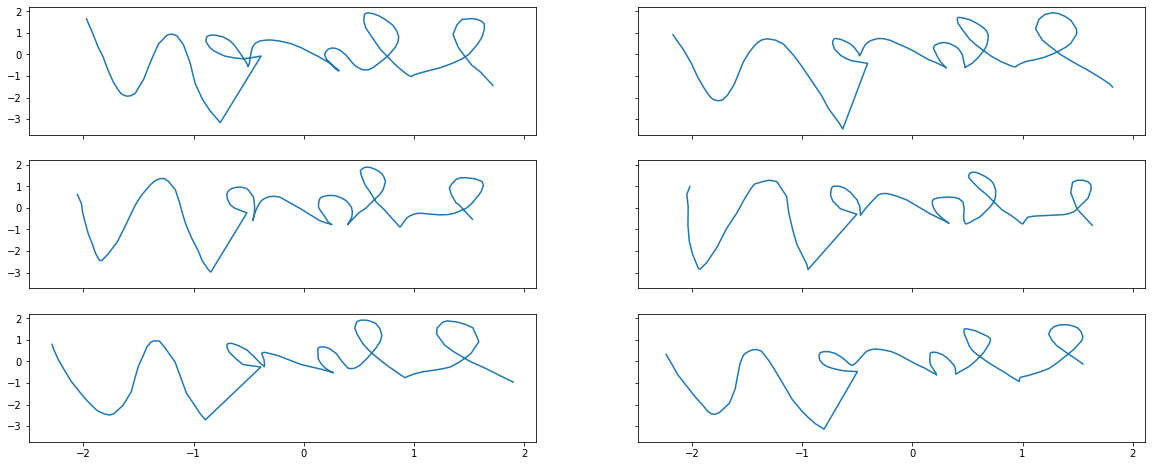

In [ ]:
fig, axs = plt.subplots(nrows=math.ceil(X_train.shape[0]/2),ncols=round(X_train.shape[0]/2), figsize=(20, 8), sharex=True, sharey=True)
for i, ax in enumerate(axs.flatten()): # Five genuine signatures in one training set
    ax.plot(X_test[i][:,0], X_test[i][:,1])

#### Develop a python program to process in sequence all these 83 tasks. We will first consider 1-NN classifiers based on the Euclidean distance (ED), the DTW distance and The Frechet’s distance.

Given the size of the final dataset (60*83) and the processing time to calculate the distances, especially considering the Frechet's distance (60*83*5*83), the dataset was set to only 5 USERs, corresponding to 300 signatures, among which 200 are genuine and 100 are forged. Another approach is to consider only the mean of the observations in each signature to reduce computation time. However, even genuine signatures may have a large variability among each other which may influence the results. Therefore, it was opted to mostly work with the entire series, but with a very reduced number of signatures. 

In [ ]:
# Stacking the 5 datasets
X_train_all = []
X_test_all = []
y_test_all = []

for i in np.sort(luid)[77:-1]: # last file is a csv, not an user
    X_train, X_test, y_test = loadTrainQuestionnedMOBISIG(i, ntrain=5, path=path)
    X_train_all.append(X_train)
    X_test_all.append(X_test)
    y_test_all.append(y_test)

X_train_ = np.asarray(X_train_all)
X_test_ = np.asarray(X_test_all)
y_test_ = np.asarray(y_test_all)

# Concatenating the users in a single array
y_test_c = np.concatenate(y_test_, axis=0)
X_test_c = np.concatenate(X_test_, axis=0)
X_train_c = np.concatenate(X_train_, axis=0)

print('X_test size:', X_test_c.shape, '\nX_train size:', X_train_c.shape)

# # Save the dataset for later use
# np.save(path+'X_train', X_train_c)
# np.save(path+'X_test', X_test_c)
# np.save(path+'y_test', y_test_c)

# # Load 5 USERS
# X_train_c = np.load(path+'X_train.npy', allow_pickle=True)
# X_test_c = np.load(path+'X_test.npy', allow_pickle=True)
# y_test_c = np.load(path+'y_test.npy', allow_pickle=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:197: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


X_test size: (300,) 
X_train size: (25,)


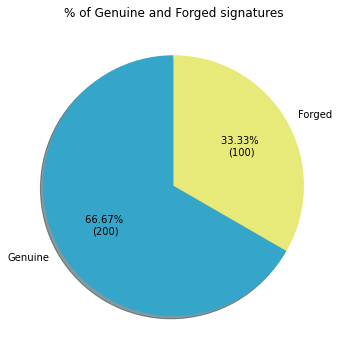

In [ ]:
# Visualizing Genuine vs Fake signatures
sizes = np.unique(np.concatenate(y_test_), return_counts=True)[1]
labels = ['Genuine', 'Forged']

def make_autopct(values):
    def my_autopct(pct):
        val = int(round(pct*sum(values)/100.0))
        return '{p:.2f}% \n({v:d})'.format(p=pct,v=val)
    return my_autopct

plt.figure(figsize=(10,6))
plt.pie(sizes, labels=labels, shadow=True, autopct=make_autopct(sizes), startangle=90, colors=['#35A6C9','#E7EA78'])
plt.title('% of Genuine and Forged signatures')
plt.show()

##### **Feature Extraction**
For each user, the dataset is divided into genuine signatures and mixed between genuine and forged signatures. In order to compute DTW, Euclidean Distance and DTW each signature on the mixed dataset was compared with 5 genuine signatures. Then the mean among the distances obtained in each interaction were calculated. The distances are then considered as input to a KNN classifier. 
In order to calculate the Euclidean Distance, genuine and mixed datasets had to be padded to the same size. In order to calculate the Frechet distance 150 random points of each signature were chosen in order to decrease the computation time. No further preprocessing were required to apply DTW.


In [ ]:
import numpy as np
np.seterr(divide='ignore', invalid='ignore')

def normalisation(X):
    return (X - np.min(X))/(np.max(X)-np.min(X))

def euclidean_distance(X_test, X_train):
    dist = []
    # Padding with zeros 
    for test in X_test:
        for train in X_train:
            diff = np.abs(len(train) - len(test))
            if len(train) > len(test):
                test_2 = np.pad(test, (np.abs((0, diff)), (0, 0)), 'constant')
                train_2 = train.copy()
            elif len(train) <= len(test):
                train_2= np.pad(train, (np.abs((0, diff)), (0, 0)), 'constant')
                test_2 = test.copy()
                
            # Euclidean Distance
            eud = dfre.euclideanDist(train_2,test_2) 
            dist.append(eud)

    # Get the min dist among the 5 distances between X_test and X_train (obtained after each full interaction)    
    min_dist = np.min(np.asarray(dist).reshape((len(X_test),len(X_train))), axis=1) 
    # Return the value (in fractional seconds) of the sum of the system and user CPU time of the current process.
    process_time = time.process_time() 
    print(f'Euclidean Distance: {process_time}')
    
    return normalisation(min_dist), process_time

def frechet_distance(X_test, X_train):
    dist = []
    for test in X_test:
        for train in X_train:
          # choosing random points from the signature to avoid too big signatures (avoids strange error later)

          length = test.shape[0] 
          idx = np.random.randint(0, length, 150)

#             Frechet
          frechet = dfre.frechet(train,test[idx,:])
          dist.append(frechet)
            
    # Get the min dist among the 5 distances between X_test and X_train (obtained after each full interaction)    
    min_dist = np.min(np.asarray(dist).reshape((len(X_test),len(X_train))), axis=1)
    process_time = time.process_time() # Return the value (in fractional seconds) of the sum of the system and user CPU time of the current process.
    print(f'Frechet Distance: {process_time}')
    return normalisation(min_dist), process_time

def dtw_distance(X_test, X_train):
    dist = []
    for test in X_test:
        for train in X_train:
            dtw_dist = dtw.dtw(test, train)
            dist.append(dtw_dist.normalizedDistance)
            
    # Get the min dist among the 5 distances between X_test and X_train (obtained after each full interaction)    
    min_dist = np.min(np.asarray(dist).reshape((len(X_test),len(X_train))), axis=1)
    process_time = time.process_time() # Return the value (in fractional seconds) of the sum of the system and user CPU time of the current process.
    print(f'DTW: {process_time}')
    return min_dist, process_time

##### **Accuracy Metrics and Processing time**

A KNN-3 classifier was used to classify the dataset. Three accuracy measures were used to compute the accuracy of each classifier: Area Under the ROC Curve (AUC), the Average Precision (AP) and the Equal Error Rate (EER). Area Under the ROC Curve plots the True Positive Rate vs the False Positive Rate. It can be seen as the probability that the model ranks a random positive example more highly than a random negative example. The greater the AUC the better your model is at making predictions. Equal Error Rate (EER) indicates where FPR is equal to FNR, the smaller the better.

Overall, DTW and Euclidean Distance had similar results for both AUC and EER score. However, the Euclidean method had better results when computing the accuracy score. Frechet distance experienced the worst performance among the classifiers in all the measured metrics.

Processing time was computed using the time.process_time() function of the python package time (Return the value (in fractional seconds) of the sum of the system and user CPU time of the current process). Frechet’s distance takes about 5 times more processing time than Euclidean and DTW.

In [ ]:
# Computing distance and processing time for DTW, Euclidean Distance and Frechet
# Single Dataset
# dist_dtw, time_dtw = dtw_distance(X_test, X_train)
# dist_euclidean, time_euclidean = euclidean_distance(X_test, X_train)
# dist_frecht, time_frecht = frechet_distance(X_test, X_train)

# 5 users Dataset 
dist_dtw, time_dtw = dtw_distance(X_test_c, X_train_c[:5])
dist_euclidean, time_euclidean = euclidean_distance(X_test_c, X_train_c[:5])
dist_frecht, time_frecht = frechet_distance(X_test_c, X_train_c[:5])

DTW: 14.410604501
Euclidean Distance: 14.534458186
Frechet Distance: 418.980274883


In [ ]:
dict_dist = {'distances':['DTW', 'Euclidean', 'Frechet'],
             'processing_time': [time_dtw, time_euclidean, time_frecht]}

distances = [dist_dtw, dist_euclidean, dist_frecht]

avg_p = []
eu_d = []

avg_p_knn = []
eu_d_knn = []

pred_knn = []
pred_proba_knn = []

for i, dist in enumerate(distances):
    # KNN
    y_test_copy = y_test_c # Remember to change for the y of the whole dataset
    X = dist.reshape(-1,1)
    y_true = np.asarray(y_test_copy)
    y = y_true.reshape(-1,1)

    # Splitting 
    X_train_k, X_test_k, y_train_k, y_test_k = train_test_split(X, y, random_state=0, test_size=0.3)

    # Fitting/Predicting
    neigh = KNeighborsClassifier(n_neighbors=3).fit(X_train_k, y_train_k.ravel())
    y_pred_knn = neigh.predict(X_test_k)
    y_proba_knn = neigh.predict_proba(X_test_k)
    
    # Accuracy Scores 
    pred_knn.append(y_pred_knn)
    pred_proba_knn.append(y_proba_knn)

    roc_score_knn = roc_auc_score(y_pred_knn, y_test_k)
    avg_prec_knn = average_precision_score(y_pred_knn, y_test_k)
    
    avg_p_knn.append(avg_prec_knn)
    eu_d_knn.append(roc_score_knn)

    # Save Accuracy scores
    dict_dist.update(avg_precison_knn=avg_p_knn,
                    roc_score_knn = eu_d_knn)

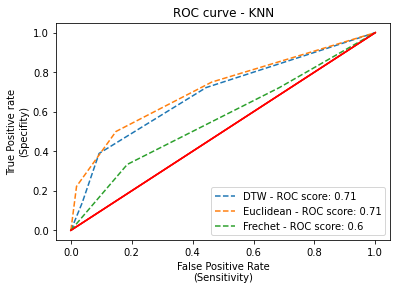

In [ ]:
# Plotting ROC Curve
eer_all = []
for i, pred_proba in enumerate(pred_proba_knn):
  fpr, tpr, thresh = roc_curve(y_test_k, pred_proba[:,1], pos_label=1)

  # Equal Error Rate
  eer = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)
  eer_all.append(eer)

  # roc curve for tpr = fpr 
  random_probs = [0 for i in range(len(y_test_k))]
  p_fpr, p_tpr, _ = roc_curve(y_test_k, random_probs, pos_label=1)

  name = dict_dist['distances'][i]
  plt.plot(fpr, tpr, linestyle='--',label= f'{name} - ROC score: {round(eu_d_knn[i],2)}')
  plt.plot(p_fpr, p_tpr, color='red') # shows where the TPR = FPR
  plt.xlabel('False Positive Rate\n(Sensitivity)')
  plt.ylabel('True Positive rate\n(Specifity)')
  plt.legend(loc='best')
  plt.title('ROC curve - KNN')

In [ ]:
dict_dist.update(eer_score = eer_all)
df = pd.DataFrame(dict_dist)
df

,distances,processing_time,avg_precison_knn,roc_score_knn,eer_score
0,DTW,14.410605,0.342105,0.713491,0.358859
1,Euclidean,14.534458,0.435043,0.705529,0.344262
2,Frechet,418.980275,0.292929,0.596257,0.456019


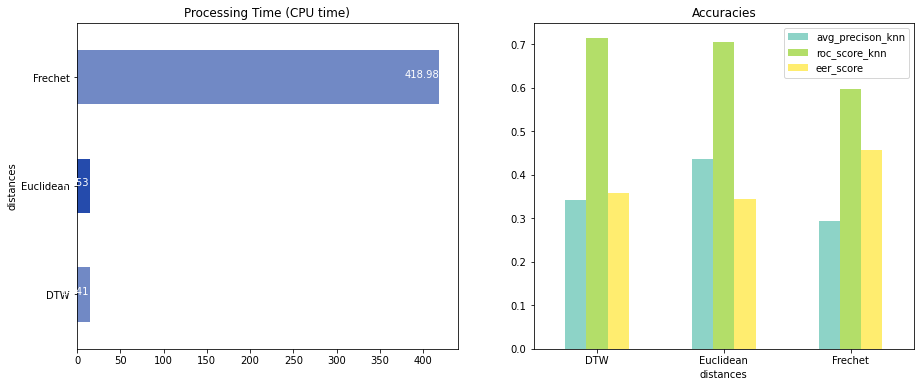

In [ ]:
figure, axes = plt.subplots(1, 2, figsize=(15,6))

df.plot.barh(y='processing_time', x='distances', legend=False, color=['#7189C5','#254BAC'], ax=axes[0])

for y, x in enumerate(round(df.processing_time, 2)):
    axes[0].annotate(str(x), xy=(x, y), ha='right', color='w')
axes[0].set_title('Processing Time (CPU time)')

df.plot.bar(y=['avg_precison_knn','roc_score_knn', 'eer_score'], x='distances',cmap='Set3',ax=axes[1])
axes[1].set_title('Accuracies')
axes[1]
plt.xticks(rotation=0)
plt.show()

## Question 3 - Implement a cross-validation procedure to tune the meta parameter σ defined in KDTW


 
##### **Use the first USER (first task) to ’optimize’ this parameters, and test KDTW with this fixed setting following the procedure setup for Question 1 (provide the mean and standard deviation for the 3 evaluation measures calculated on the 82 remaining tasks).**

KDTW is derived from DTW while ensuring the property that KDTW(.,.) is a positive definite kernel (@pfmarteau). It has a smoothing parameter sigma, responsible to scale the local distances computations. 
k(x,y) = 1/3.(exp{-d²(x,y)/sigma}+epsilon)/(1+epsilon)
A K-Fold cross validation procedure was set to estimate the best sigma values. I had some issues while computing KDTW, regarding the sigmas and the signatures size. In regard to the sigmas, setting small sigmas returned values equal or too close to 0, which then later resulted in few strange errors. I therefore used high sigmas values, resulting in a broader smoothing effect .  In regard to the signature size, some signatures, specially the forged ones, have considerably more data points than genuine signatures. When using the complete size of the signature, I got few out of bounds errors, related to the distance computation. In order to solve this problem, I random sample 150 points from both the train and test dataset.
After running the cross validation of the sigma hyperparameter, the mean was calculated for each of the 5 folders. Sigma = 100 experienced the best results.

KFold implementation follows: https://towardsdatascience.com/complete-guide-to-pythons-cross-validation-with-examples-a9676b5cac12

In [ ]:
from sklearn.model_selection import KFold
from sklearn.utils import shuffle
import kdtw_cdist
import kdtw

In [ ]:
?kdtw

In [ ]:
# KDTW
def kdtw_(X_test, X_train, sigma):
  dist = [] 
  for test in X_test: 
      for train in X_train:
          # choosing random points from the signature to avoid too big signatures (avoids strange error later)
          length = test.shape[0] 
          idx = np.random.randint(0, length, 150)

          kdtw_bol = kdtw.kdtw(test[idx,:], train, sigma)
          
          dist.append(kdtw_bol)
            
  # # Get the min dist among the 5 distances between X_test and X_train (obtained after each full interaction) 
  min_dist = np.min(np.asarray(dist).reshape((len(X_test),len(X_train))), axis=1)
  process_time = time.process_time() # Return the value (in fractional seconds) of the sum of the system and user CPU time of the current process.
  # print(f'CPU Time: {process_time}')
  
  return min_dist, process_time

In [ ]:
# Sigma Optimization
X_train, X_test, y_test = loadTrainQuestionnedMOBISIG(luid[0], ntrain=5, path=path)
X_test, y_test = shuffle(X_test, y_test, random_state=42)

y_test = np.asarray(y_test)

# Hyperparameter to optmize
sigmas = np.linspace(1, 100, 5)

# Spliting the data into n folds
kf = KFold(n_splits=5, shuffle=True) 

print('X_train shape: ', X_train.shape, '\nX_test shape', X_test.shape, '\ny_test shape:', y_test.shape)
print('sigmas:', sigmas)

X_train shape:  (5,) 
X_test shape (60,) 
y_test shape: (60,)
sigmas: [  1.    25.75  50.5   75.25 100.  ]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:197: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
# Cross Validation *-- Takes about 2 hours to run
byfold_output=[]
final_scores = {}

for train_idx, test_idx in kf.split(y_test): 
  # train set
  xtrain, ytrain = X_test[train_idx], y_test[train_idx]  
  # validation set
  xtest, ytest = X_test[test_idx], y_test[test_idx]

  # Sigma Optmization
  for sig in sigmas:
    train_kdtw,_ = kdtw_(xtrain, X_train, sigma=sig) # X_test = xtrain
    test_kdtw,_ =  kdtw_(xtest, X_train, sigma=sig) # X_test = xtest
    # print(f'\nCalculating distances for sigma = {sig}')

    # Fitting/Evaluating
    neigh = KNeighborsClassifier(n_neighbors=3).fit(train_kdtw.reshape(-1,1), ytrain)
    acc = neigh.score(test_kdtw.reshape(-1,1), ytest)
    # print(f'Model evaluation for sigma = {sig}')

    # Accuracy Scores
    final_scores.update({sig:acc})
    print(final_scores)
  byfold_output.append(final_scores.copy())

{1.0: 0.6666666666666666}
{1.0: 0.6666666666666666, 25.75: 0.6666666666666666}
{1.0: 0.6666666666666666, 25.75: 0.6666666666666666, 50.5: 0.5}
{1.0: 0.6666666666666666, 25.75: 0.6666666666666666, 50.5: 0.5, 75.25: 0.75}
{1.0: 0.6666666666666666, 25.75: 0.6666666666666666, 50.5: 0.5, 75.25: 0.75, 100.0: 0.75}
{1.0: 0.5833333333333334, 25.75: 0.6666666666666666, 50.5: 0.5, 75.25: 0.75, 100.0: 0.75}
{1.0: 0.5833333333333334, 25.75: 0.75, 50.5: 0.5, 75.25: 0.75, 100.0: 0.75}
{1.0: 0.5833333333333334, 25.75: 0.75, 50.5: 0.5833333333333334, 75.25: 0.75, 100.0: 0.75}
{1.0: 0.5833333333333334, 25.75: 0.75, 50.5: 0.5833333333333334, 75.25: 0.4166666666666667, 100.0: 0.75}
{1.0: 0.5833333333333334, 25.75: 0.75, 50.5: 0.5833333333333334, 75.25: 0.4166666666666667, 100.0: 0.75}
{1.0: 0.5833333333333334, 25.75: 0.75, 50.5: 0.5833333333333334, 75.25: 0.4166666666666667, 100.0: 0.75}
{1.0: 0.5833333333333334, 25.75: 0.5833333333333334, 50.5: 0.5833333333333334, 75.25: 0.4166666666666667, 100.0: 0.75}

In [ ]:
# Compute the mean
best_acc = {sigma:np.mean([kfold[sigma] for kfold in byfold_output]) for sigma in sigmas}
best_acc 

{1.0: 0.6666666666666667,
 25.75: 0.6666666666666667,
 50.5: 0.55,
 75.25: 0.55,
 100.0: 0.7833333333333333}

In [ ]:
# Compute KDTW with the best sigma
dist_kdtw = kdtw_(X_test_c,X_train_c[:5], sigma=best_acc[100.0]) # X_test = xtrain

In [ ]:
# KNN
X = dist_kdtw[0].reshape(-1,1)
y = y_test_c.reshape(-1,1)

# Splitting intro Train and Test
X_train_kdtw, X_test_kdtw, y_train_kdtw, y_test_kdtw = train_test_split(X, y, random_state=0, test_size=0.3)

# Fitting/Predicting
neigh_kdtw = KNeighborsClassifier(n_neighbors=3).fit(X_train_kdtw, y_train_kdtw)
y_pred_kdtw = neigh_kdtw.predict(X_test_kdtw)
y_proba_kdtw = neigh_kdtw.predict_proba(X_test_kdtw)
score = neigh_kdtw.score(X_test_kdtw,y_test_kdtw)
# Accuracy Scores 
# roc_score_kdtw = roc_auc_score(y_pred_kdtw , y_test_kdtw) # not possible to calculate roc score because only one class was classified
avg_prec_kdtw = average_precision_score(y_pred_kdtw , y_test_kdtw)

/usr/local/lib/python3.7/dist-packages/sklearn/neighbors/_classification.py:198: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [ ]:
# Plotting ROC Curve
fpr, tpr, thresh = roc_curve(y_test_kdtw, y_proba_kdtw [:,1], pos_label=1)
# Equal Error Rate
eer_kdtw = brentq(lambda x : 1. - x - interp1d(fpr, tpr)(x), 0., 1.)

# roc curve for tpr = fpr 
random_probs = [0 for i in range(len(y_test_kdtw))]
p_fpr, p_tpr, _ = roc_curve(y_test_kdtw, random_probs, pos_label=1)

In [ ]:
df_kdtw=pd.DataFrame({'avg_precison_knn': score, 'distances':'KDTW', 
                      'processing_time': dist_kdtw[1], 'eer_score':eer_kdtw}, index=[3])

In [ ]:
final_df = pd.concat([df_kdtw,df])
final_df

,avg_precison_knn,distances,processing_time,eer_score,roc_score_knn
3,0.400000,KDTW,3448.780356,0.500000,NaN
0,0.342105,DTW,14.410605,0.358859,0.713491
1,0.435043,Euclidean,14.534458,0.344262,0.705529
2,0.292929,Frechet,418.980275,0.456019,0.596257


### Question 4 - Critical Difference Diagrams

Using the (Method v.s. TaskID) matrices, and the Critical Difference Diagrams package (Friedman’s test followed by a post-hoc analysis based on the Wilcoxon-Holm method) https://github.com/hfawaz/cd-diagram, rank the four tested classifiers according to the Friedman’s tests and Nemenyi’s post-hoc test on the basis of the 82 classification tasks (without exploiting USER 1).


In [ ]:
from main import * # Critical Difference Diagrams
?draw_cd_diagram

##### Critical Difference Diagrams package (Friedman’s test followed by a post-hoc analysis based on the Wilcoxon-Holm method) https://github.com/hfawaz/cd-diagram

In [ ]:
import numpy as np
import pandas as pd
import matplotlib

matplotlib.use('agg')
import matplotlib.pyplot as plt

matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rcParams['font.sans-serif'] = 'Arial'

import operator
import math
from scipy.stats import wilcoxon
from scipy.stats import friedmanchisquare
import networkx

# inspired from orange3 https://docs.orange.biolab.si/3/data-mining-library/reference/evaluation.cd.html
def graph_ranks(avranks, names, p_values, cd=None, cdmethod=None, lowv=None, highv=None,
                width=6, textspace=1, reverse=False, filename=None, labels=False, **kwargs):
    """
    Draws a CD graph, which is used to display  the differences in methods'
    performance. See Janez Demsar, Statistical Comparisons of Classifiers over
    Multiple Data Sets, 7(Jan):1--30, 2006.
    Needs matplotlib to work.
    The image is ploted on `plt` imported using
    `import matplotlib.pyplot as plt`.
    Args:
        avranks (list of float): average ranks of methods.
        names (list of str): names of methods.
        cd (float): Critical difference used for statistically significance of
            difference between methods.
        cdmethod (int, optional): the method that is compared with other methods
            If omitted, show pairwise comparison of methods
        lowv (int, optional): the lowest shown rank
        highv (int, optional): the highest shown rank
        width (int, optional): default width in inches (default: 6)
        textspace (int, optional): space on figure sides (in inches) for the
            method names (default: 1)
        reverse (bool, optional):  if set to `True`, the lowest rank is on the
            right (default: `False`)
        filename (str, optional): output file name (with extension). If not
            given, the function does not write a file.
        labels (bool, optional): if set to `True`, the calculated avg rank
        values will be displayed
    """
    try:
        import matplotlib
        import matplotlib.pyplot as plt
        from matplotlib.backends.backend_agg import FigureCanvasAgg
    except ImportError:
        raise ImportError("Function graph_ranks requires matplotlib.")

    width = float(width)
    textspace = float(textspace)

    def nth(l, n):
        """
        Returns only nth elemnt in a list.
        """
        n = lloc(l, n)
        return [a[n] for a in l]

    def lloc(l, n):
        """
        List location in list of list structure.
        Enable the use of negative locations:
        -1 is the last element, -2 second last...
        """
        if n < 0:
            return len(l[0]) + n
        else:
            return n

    def mxrange(lr):
        """
        Multiple xranges. Can be used to traverse matrices.
        This function is very slow due to unknown number of
        parameters.
        >>> mxrange([3,5])
        [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]
        >>> mxrange([[3,5,1],[9,0,-3]])
        [(3, 9), (3, 6), (3, 3), (4, 9), (4, 6), (4, 3)]
        """
        if not len(lr):
            yield ()
        else:
            # it can work with single numbers
            index = lr[0]
            if isinstance(index, int):
                index = [index]
            for a in range(*index):
                for b in mxrange(lr[1:]):
                    yield tuple([a] + list(b))

    def print_figure(fig, *args, **kwargs):
        canvas = FigureCanvasAgg(fig)
        canvas.print_figure(*args, **kwargs)

    sums = avranks

    nnames = names
    ssums = sums

    if lowv is None:
        lowv = min(1, int(math.floor(min(ssums))))
    if highv is None:
        highv = max(len(avranks), int(math.ceil(max(ssums))))

    cline = 0.4

    k = len(sums)

    lines = None

    linesblank = 0
    scalewidth = width - 2 * textspace

    def rankpos(rank):
        if not reverse:
            a = rank - lowv
        else:
            a = highv - rank
        return textspace + scalewidth / (highv - lowv) * a

    distanceh = 0.25

    cline += distanceh

    # calculate height needed height of an image
    minnotsignificant = max(2 * 0.2, linesblank)
    height = cline + ((k + 1) / 2) * 0.2 + minnotsignificant

    fig = plt.figure(figsize=(width, height))
    fig.set_facecolor('white')
    ax = fig.add_axes([0, 0, 1, 1])  # reverse y axis
    ax.set_axis_off()

    hf = 1. / height  # height factor
    wf = 1. / width

    def hfl(l):
        return [a * hf for a in l]

    def wfl(l):
        return [a * wf for a in l]

    # Upper left corner is (0,0).
    ax.plot([0, 1], [0, 1], c="w")
    ax.set_xlim(0, 1)
    ax.set_ylim(1, 0)

    def line(l, color='k', **kwargs):
        """
        Input is a list of pairs of points.
        """
        ax.plot(wfl(nth(l, 0)), hfl(nth(l, 1)), color=color, **kwargs)

    def text(x, y, s, *args, **kwargs):
        ax.text(wf * x, hf * y, s, *args, **kwargs)

    line([(textspace, cline), (width - textspace, cline)], linewidth=2)

    bigtick = 0.3
    smalltick = 0.15
    linewidth = 2.0
    linewidth_sign = 4.0

    tick = None
    for a in list(np.arange(lowv, highv, 0.5)) + [highv]:
        tick = smalltick
        if a == int(a):
            tick = bigtick
        line([(rankpos(a), cline - tick / 2),
              (rankpos(a), cline)],
             linewidth=2)

    for a in range(lowv, highv + 1):
        text(rankpos(a), cline - tick / 2 - 0.05, str(a),
             ha="center", va="bottom", size=16)

    k = len(ssums)

    def filter_names(name):
        return name

    space_between_names = 0.24

    for i in range(math.ceil(k / 2)):
        chei = cline + minnotsignificant + i * space_between_names
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace - 0.1, chei)],
             linewidth=linewidth)
        if labels:
            text(textspace + 0.3, chei - 0.075, format(ssums[i], '.4f'), ha="right", va="center", size=10)
        text(textspace - 0.2, chei, filter_names(nnames[i]), ha="right", va="center", size=16)

    for i in range(math.ceil(k / 2), k):
        chei = cline + minnotsignificant + (k - i - 1) * space_between_names
        line([(rankpos(ssums[i]), cline),
              (rankpos(ssums[i]), chei),
              (textspace + scalewidth + 0.1, chei)],
             linewidth=linewidth)
        if labels:
            text(textspace + scalewidth - 0.3, chei - 0.075, format(ssums[i], '.4f'), ha="left", va="center", size=10)
        text(textspace + scalewidth + 0.2, chei, filter_names(nnames[i]),
             ha="left", va="center", size=16)

    # no-significance lines
    def draw_lines(lines, side=0.05, height=0.1):
        start = cline + 0.2

        for l, r in lines:
            line([(rankpos(ssums[l]) - side, start),
                  (rankpos(ssums[r]) + side, start)],
                 linewidth=linewidth_sign)
            start += height
            # print('drawing: ', l, r)

    # draw_lines(lines)
    start = cline + 0.2
    side = -0.02
    height = 0.1

    # draw no significant lines
    # get the cliques
    cliques = form_cliques(p_values, nnames)
    i = 1
    achieved_half = False
    #print(nnames)
    for clq in cliques:
        if len(clq) == 1:
            continue
        #print(clq)
        min_idx = np.array(clq).min()
        max_idx = np.array(clq).max()
        if min_idx >= len(nnames) / 2 and achieved_half == False:
            start = cline + 0.25
            achieved_half = True
        line([(rankpos(ssums[min_idx]) - side, start),
              (rankpos(ssums[max_idx]) + side, start)],
             linewidth=linewidth_sign)
        start += height


def form_cliques(p_values, nnames):
    """
    This method forms the cliques
    """
    # first form the numpy matrix data
    m = len(nnames)
    g_data = np.zeros((m, m), dtype=np.int64)
    for p in p_values:
        if p[3] == False:
            i = np.where(nnames == p[0])[0][0]
            j = np.where(nnames == p[1])[0][0]
            min_i = min(i, j)
            max_j = max(i, j)
            g_data[min_i, max_j] = 1

    g = networkx.Graph(g_data)
    return networkx.find_cliques(g)


def draw_cd_diagram(df_perf=None, alpha=0.05, title=None, labels=False):
    """
    Draws the critical difference diagram given the list of pairwise classifiers that are
    significant or not
    """
    p_values, average_ranks, _ = wilcoxon_holm(df_perf=df_perf, alpha=alpha)

    # print(average_ranks)

    # for p in p_values:
    #    print(p)


    graph_ranks(average_ranks.values, average_ranks.keys(), p_values,
                cd=None, reverse=True, width=15, textspace=1.5, labels=labels)

    font = {'family': 'sans-serif',
        'color':  'black',
        'weight': 'normal',
        'size': 22,
        }
    if title:
        plt.title(title,fontdict=font, y=0.9, x=0.5)
    plt.savefig('cd-diagram.png',bbox_inches='tight')
    plt.show()

def wilcoxon_holm(alpha=0.05, df_perf=None):
    """
    Applies the wilcoxon signed rank test between each pair of algorithm and then use Holm
    to reject the null's hypothesis
    """
    # print(pd.unique(df_perf['classifier_name']))
    # count the number of tested datasets per classifier
    df_counts = pd.DataFrame({'count': df_perf.groupby(
        ['classifier_name']).size()}).reset_index()
    # get the maximum number of tested datasets
    max_nb_datasets = df_counts['count'].max()
    # get the list of classifiers who have been tested on nb_max_datasets
    classifiers = list(df_counts.loc[df_counts['count'] == max_nb_datasets]
                       ['classifier_name'])
    # test the null hypothesis using friedman before doing a post-hoc analysis
    friedman_p_value = friedmanchisquare(*(
        np.array(df_perf.loc[df_perf['classifier_name'] == c]['accuracy'])
        for c in classifiers))[1]
    if friedman_p_value >= alpha:
        # then the null hypothesis over the entire classifiers cannot be rejected
        print('the null hypothesis over the entire classifiers cannot be rejected')
        exit()
    # get the number of classifiers
    m = len(classifiers)
    # init array that contains the p-values calculated by the Wilcoxon signed rank test
    p_values = []
    # loop through the algorithms to compare pairwise
    for i in range(m - 1):
        # get the name of classifier one
        classifier_1 = classifiers[i]
        # get the performance of classifier one
        perf_1 = np.array(df_perf.loc[df_perf['classifier_name'] == classifier_1]['accuracy']
                          , dtype=np.float64)
        for j in range(i + 1, m):
            # get the name of the second classifier
            classifier_2 = classifiers[j]
            # get the performance of classifier one
            perf_2 = np.array(df_perf.loc[df_perf['classifier_name'] == classifier_2]
                              ['accuracy'], dtype=np.float64)
            # calculate the p_value
            p_value = wilcoxon(perf_1, perf_2, zero_method='pratt')[1]
            # appen to the list
            p_values.append((classifier_1, classifier_2, p_value, False))
    # get the number of hypothesis
    k = len(p_values)
    # sort the list in acsending manner of p-value
    p_values.sort(key=operator.itemgetter(2))

    # loop through the hypothesis
    for i in range(k):
        # correct alpha with holm
        new_alpha = float(alpha / (k - i))
        # test if significant after holm's correction of alpha
        if p_values[i][2] <= new_alpha:
            p_values[i] = (p_values[i][0], p_values[i][1], p_values[i][2], True)
        else:
            # stop
            break
    # compute the average ranks to be returned (useful for drawing the cd diagram)
    # sort the dataframe of performances
    sorted_df_perf = df_perf.loc[df_perf['classifier_name'].isin(classifiers)]. \
        sort_values(['classifier_name', 'dataset_name'])
    # get the rank data
    rank_data = np.array(sorted_df_perf['accuracy']).reshape(m, max_nb_datasets)

    # create the data frame containg the accuracies
    df_ranks = pd.DataFrame(data=rank_data, index=np.sort(classifiers), columns=
    np.unique(sorted_df_perf['dataset_name']))

    # number of wins
    dfff = df_ranks.rank(ascending=False)
    #print(dfff[dfff == 1.0].sum(axis=1))

    # average the ranks
    average_ranks = df_ranks.rank(ascending=False).mean(axis=1).sort_values(ascending=False)
    # return the p-values and the average ranks
    return p_values, average_ranks, max_nb_datasets

##### Rank of the Classifiers (DTW, Euclidean, Frechet, KDTW)

In [ ]:
# DF with accuracies
roc_scores = final_df["roc_score_knn"]
method = final_df["distances"]
cdd = pd.DataFrame({"classifier_name": method, "accuracy":roc_scores})

In [ ]:
draw_cd_diagram(df_perf=cdd, title="Roc Score", labels=True) # should have computed cross - validation to all the classifiers to ave enough accuracies to compare

['KDTW' 'DTW' 'Euclidean' 'Frechet']
the null hypothesis over the entire classifiers cannot be rejected


/usr/local/lib/python3.7/dist-packages/scipy/stats/morestats.py:2879: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


KeyError: ignored

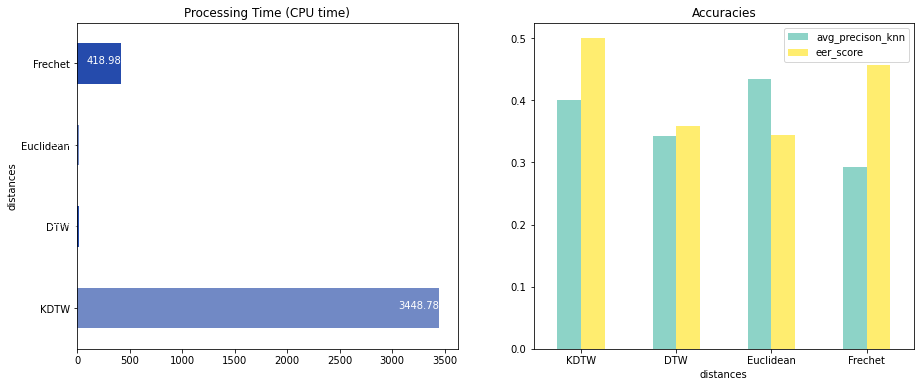

In [ ]:
figure, axes = plt.subplots(1, 2, figsize=(15,6))

final_df.plot.barh(y='processing_time', x='distances', legend=False, color=['#7189C5','#254BAC'], ax=axes[0])

for y, x in enumerate(round(final_df.processing_time, 2)):
    axes[0].annotate(str(x), xy=(x, y), ha='right', color='w')
axes[0].set_title('Processing Time (CPU time)')

final_df.plot.bar(y=['avg_precison_knn', 'eer_score'], x='distances',cmap='Set3',ax=axes[1])
axes[1].set_title('Accuracies')
axes[1]
plt.xticks(rotation=0)
plt.show()